In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

In [205]:
#definition of FourierTransforms
def matsubara_fft(G_tau):
    N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
def matsubara_fft_trick(G_tau):
    N = G_tau.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft( (G_tau+0.5) *np.exp(1j*np.pi*k/N)) + 1./(1j*freq)
#numpy orders frequencies differently so one has to convert frequencies
def matsubara_freq(N):
    return np.pi/beta *(-2.*N*( np.array(np.fft.fftfreq(N),dtype=np.float128) ) +1.)
def matsubara_ifft(G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype='float')
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
def matsubara_ifft_trick(G_omega):
    N = G_omega.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N,dtype='float')
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )

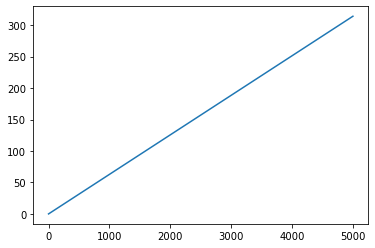

In [213]:
N = 5000
beta = 100
D = 1.0
n = 50
tol = 1e-4
frac_new = 0.75

freq = matsubara_freq(N)
freq = np.pi/beta * (2*np.arange(N)+1)
plt.plot(freq)

In [214]:
def self_energy(G0_omega,U):
    G0_tau = matsubara_ifft_trick(G0_omega)
    G0_minus_tau = -np.roll(G0_tau[::-1],1)
    G0_minus_tau[0] = -G0_minus_tau[0]
    sigma_tau = -U*U * G0_tau*G0_tau * G0_minus_tau
    return matsubara_fft_trick(sigma_tau)

def dos_bethe(e):
    return 2.0/(np.pi*D)*np.sqrt(1.0-(e/D)**2)

def Gloc_omega(self_energy_omega, U):
    mu = U/2.0
    e = np.linspace(-D,D,N)
    de = e[2] - e[1]
    return simps(dos_bethe(e)/(1j*freq[:,np.newaxis] -e -self_energy_omega[:,np.newaxis]), dx = de)

def DMFT_step(Ginitial, U, frac_new):
    mu = U/2.0
    Gloc = Ginitial.copy()
    G0 = 1.0/(1j*freq - (D/2)**2 * Gloc)
    self_e = self_energy(G0, U)
    Gloc = 1./(1./G0 - self_e)
    #Gloc = Gloc_omega(self_e, U)
    Gloc = frac_new*Gloc + (1.0-frac_new)*Ginitial
    return G0, Gloc

def IPT(U):
    g_0 = np.random.rand(freq.shape[0]) + 1j* np.random.rand(freq.shape[0])
    G_old = np.zeros_like(g_0)
    for i in range(n):
        g_0, G_new = DMFT_step(G_old, U, frac_new)
        diff = np.mean(np.abs(G_new-G_old))
        G_old = G_new.copy()
        if diff < tol : break
    return G_new

def IPT_(U, G00):
    G_old = G00.copy()
    for i in range(n):
        g_0, G_new = DMFT_step(G_old, U, frac_new)
        diff = np.mean(np.abs(G_new-G_old))
        G_old = G_new.copy()
        if diff < tol : break
    return G_new

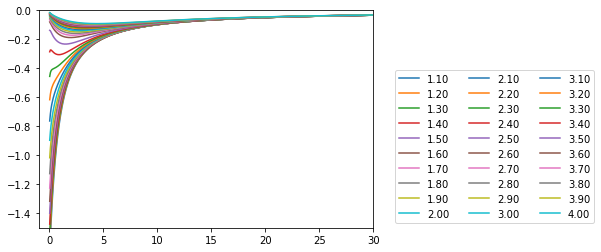

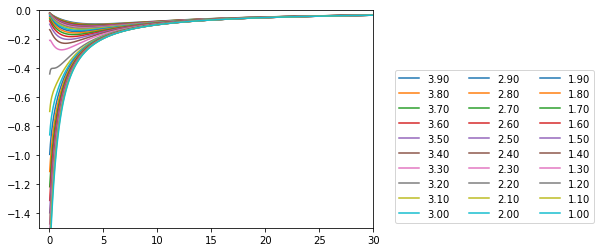

In [215]:
U = np.array([0.01*i for i in range(101, 401)])
G = IPT(1.5)
for i,u in enumerate(U):
    G = IPT_(u, G)
    if i%10==9: plt.plot(freq.real, G.imag, '-', label = f'{u:.2f}')
plt.xlim(-1, 30)
plt.ylim(-1.5, 0)
plt.legend(bbox_to_anchor=(1.05, 0), loc = 3, ncol=3)
plt.show()


U = np.array([0.01*i for i in range(100, 400)])
G = IPT(3.5)
for i,u in enumerate(np.flip(U)):
    G = IPT_(u, G)
    if i%10==9: plt.plot(freq.real, G.imag, '-', label = f'{u:.2f}')
plt.xlim(-1, 30)
plt.ylim(-1.5, 0)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, ncol=3)
plt.show()

In [216]:
U = np.array([0.01*i for i in range(101, 401)])
G = IPT(1.0)
np.savetxt(f'./1to4_0.01/Giw-1.00.dat', np.array([freq.real, G.real, G.imag]).T)
for u in U:
    G = IPT_(u, G)
    np.savetxt(f'./1to4_0.01/Giw-{u:.2f}.dat', np.array([freq.real, G.real, G.imag]).T)

U = np.array([0.01*i for i in range(100, 400)])
G = IPT(4.0)
np.savetxt(f'./4to1_0.01/Giw-4.00.dat', np.array([freq.real, G.real, G.imag]).T)
for u in np.flip(U):
    G = IPT_(u, G)
    np.savetxt(f'./4to1_0.01/Giw-{u:.2f}.dat', np.array([freq.real, G.real, G.imag]).T)